In [16]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [17]:
BOARD_ROWS = 3
BOARD_COLS = 3

In [18]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        self.playerSymbol = 1
        self.reward1 = [0]
        self.reward2 = [0]
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # str
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diag
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
            self.reward1.append(self.reward1[-1] + 1)
            self.reward2.append(self.reward2[-1] - 1)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
            self.reward1.append(self.reward1[-1] - 1)
            self.reward2.append(self.reward2[-1] + 1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)
            self.reward1.append(self.reward1[-1] + 0.1)
            self.reward2.append(self.reward2[-1] + 0.5)

    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds=100):
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)

                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')




In [19]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()


In [20]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass



In [28]:
# training
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("training...")
st.play(50000)


training...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


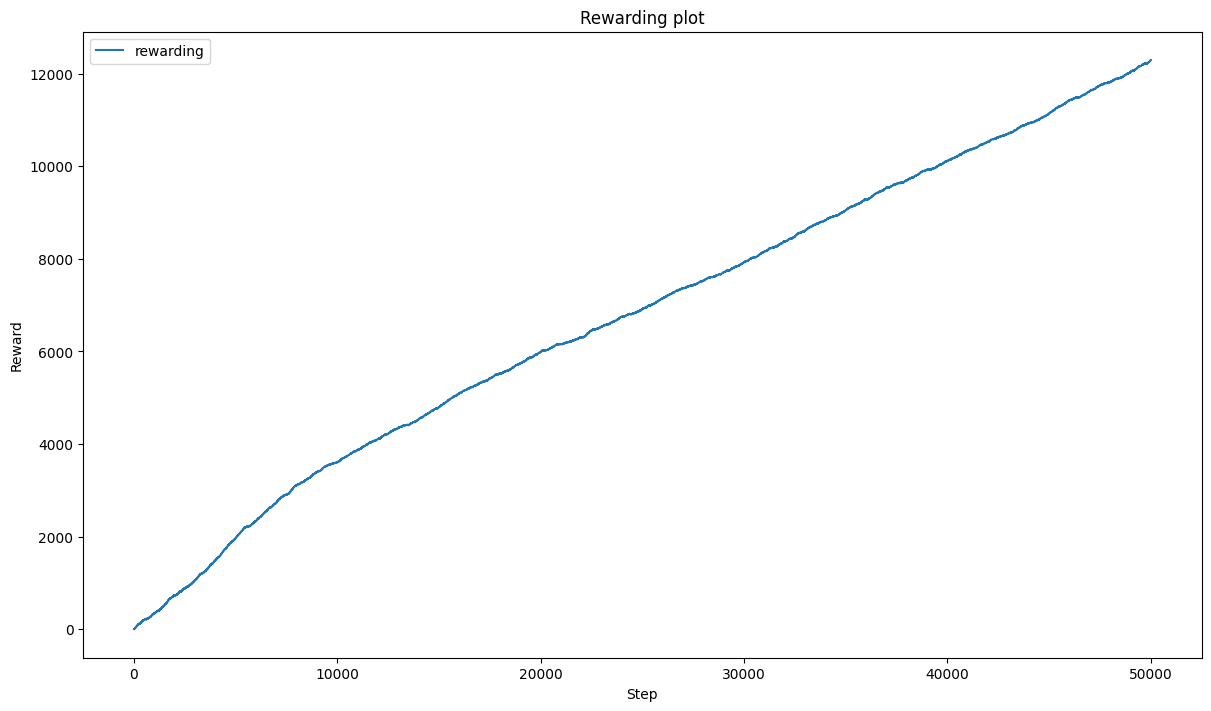

In [29]:
x = np.linspace(0, 50000, num=50001)

fig, ax = plt.subplots(figsize=(12,7), layout='constrained')
ax.plot(st.reward1, label='rewarding')
ax.set_xlabel('Step')
ax.set_ylabel('Reward')
ax.set_title("Rewarding plot")
ax.legend()
plt.savefig('Rewarding plot')

In [30]:
p1.savePolicy()
p2.savePolicy()

In [31]:
p1.loadPolicy("policy_p1")
p2 = HumanPlayer("human")
st = State(p1,p2)
st.play2()

-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
Input your action row:0
Input your action col:0
-------------
| o |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
| o |   |   | 
-------------
| x | x |   | 
-------------
|   |   |   | 
-------------
Input your action row:1
Input your action col:2
-------------
| o |   |   | 
-------------
| x | x | o | 
-------------
|   |   |   | 
-------------
-------------
| o |   | x | 
-------------
| x | x | o | 
-------------
|   |   |   | 
-------------
Input your action row:2
Input your action col:0
-------------
| o |   | x | 
-------------
| x | x | o | 
-------------
| o |   |   | 
-------------
-------------
| o | x | x | 
-------------
| x | x | o | 
-------------
| o |   |   | 
-------------
Input your action row:2
Input your action col:1
-------------
| o | x | x | 
-------------
| x | x | o | 
-------------
| o | o |   | 
-------------
